# Demonstrate full circle: prediction of components, inversion, point source fitting

In [1]:
%matplotlib inline

import os
import sys
import copy

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.operations import create_visibility, sum_visibility
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration

from matplotlib import pyplot as plt

from arl.skymodel.operations import create_skycomponent, find_skycomponents, fit_skycomponent, find_nearest_component
from arl.image.operations import show_image, export_image_to_fits
from arl.image.iterators import raster_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)

### Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

### We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 8.0)
frequency = numpy.array([1e8])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox=2000.0)

params = {'npixel':256,
          'cellsize': 0.001,
          'npol': 1,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8}

vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, params=params)

### Fill in with point sources

In [4]:
flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, params=params)
centre_ra  = model.wcs.wcs.crpix[0]-1
centre_dec = model.wcs.wcs.crpix[1]-1
spacing_pixels = params['npixel'] // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * params['cellsize'] * spacing_pixels / numpy.pi
centers = -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in centers:
    for ix in centers:
        pra, pdec = int(round(centre_ra + ix * spacing_pixels)),\
                    int(round(centre_dec + iy * spacing_pixels))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
        original_comps.append(comp)
        predict_skycomponent_visibility(vt, comp)

### Make the image using the different approaches

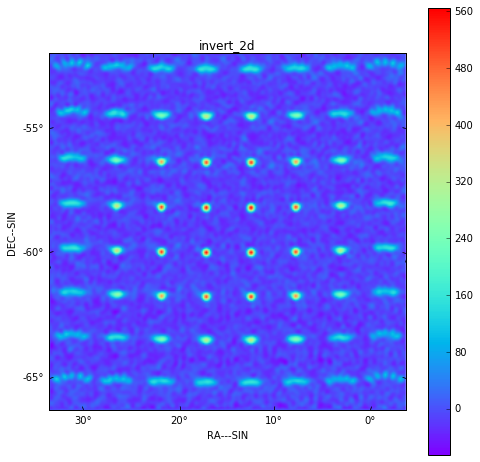

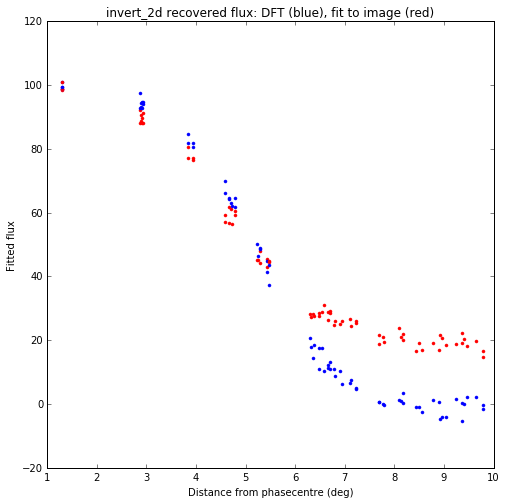

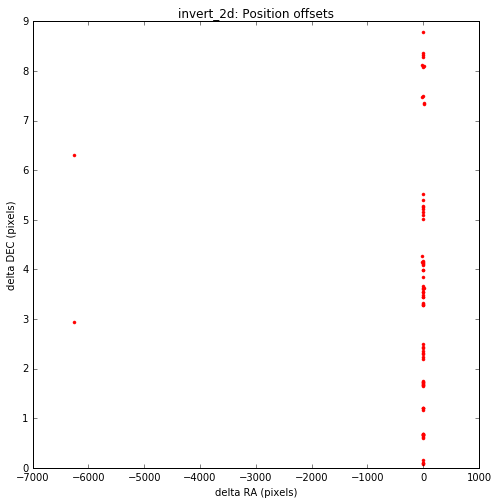

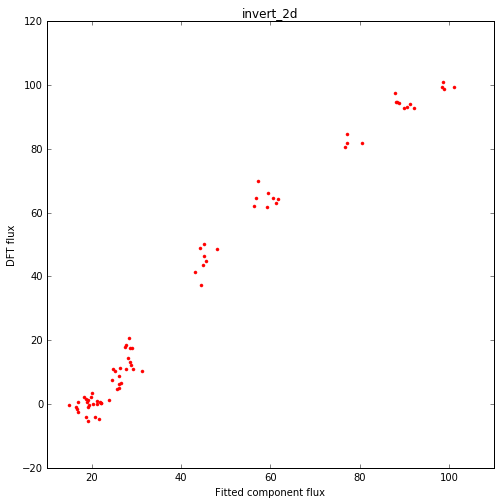

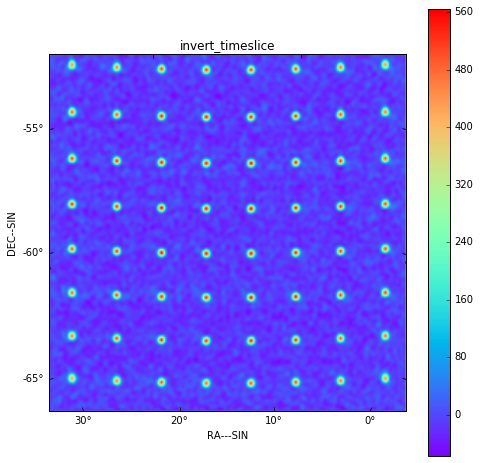

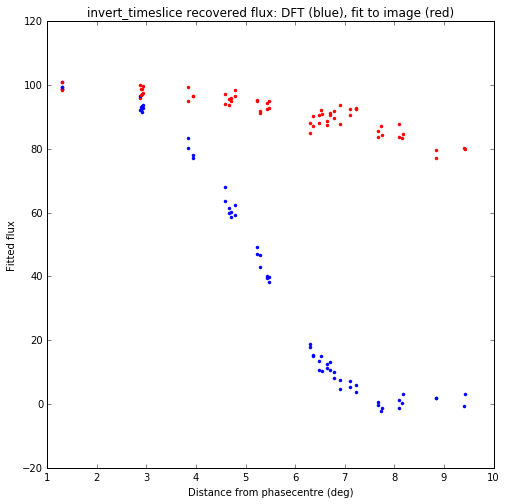

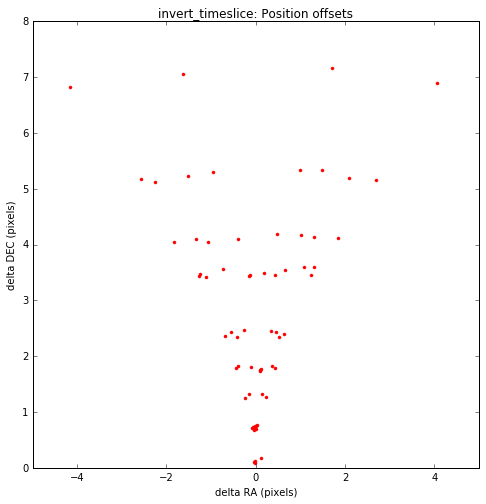

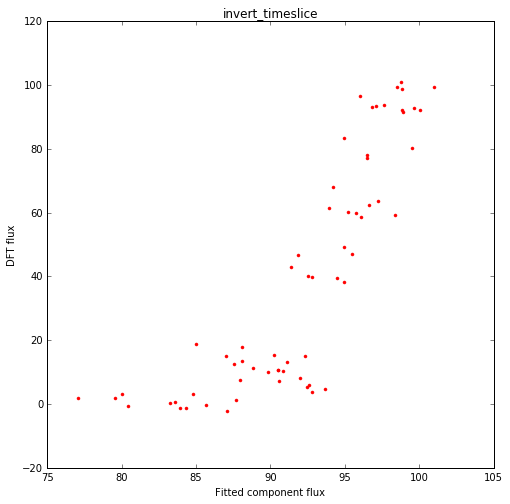

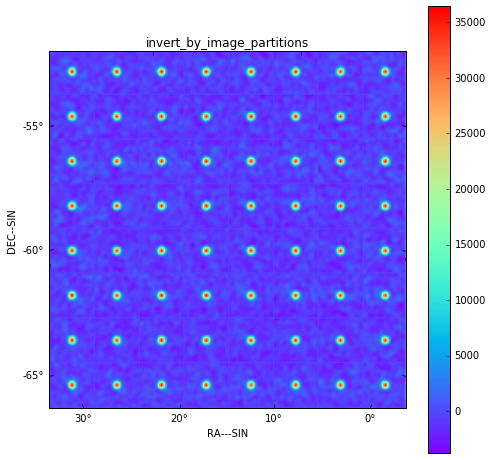

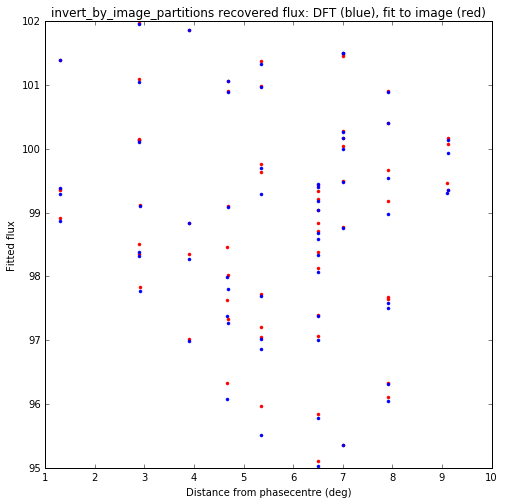

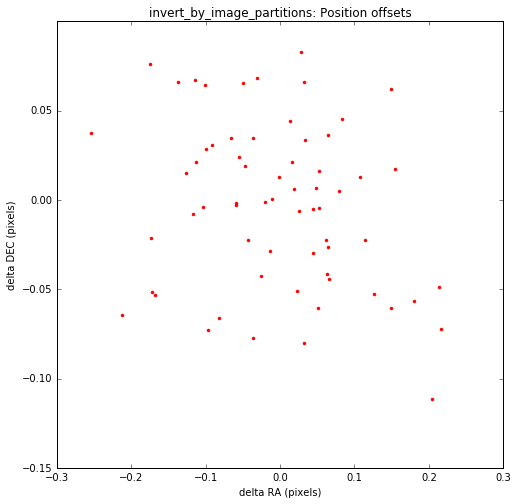

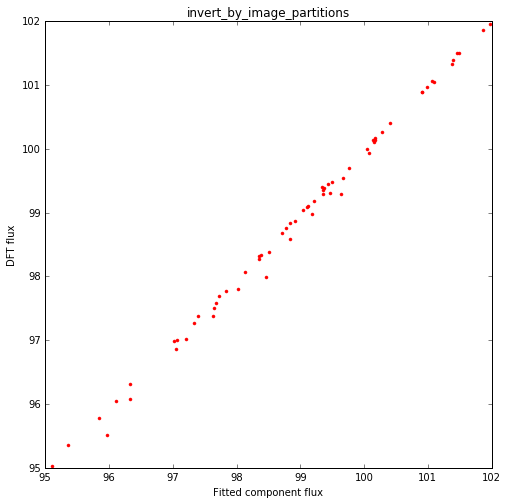

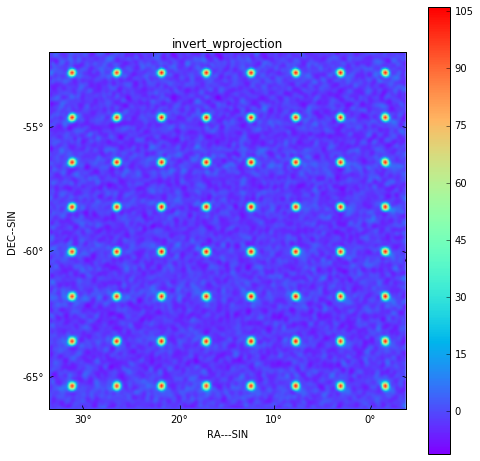

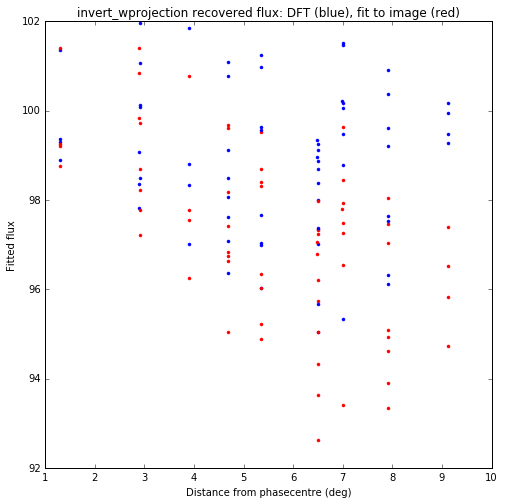

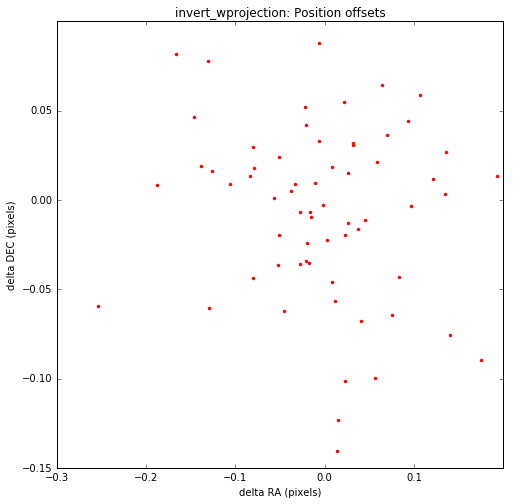

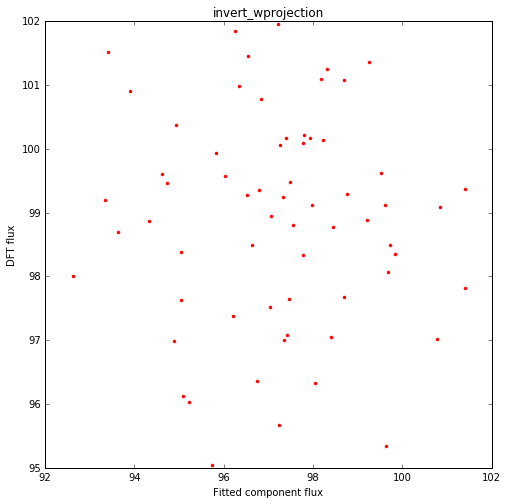

In [5]:

for processor in [invert_2d, invert_timeslice, invert_by_image_partitions, invert_wprojection]:

    params = {'npixel': 256,
              'npol': 1,
              'cellsize': 0.001,
              'spectral_mode': 'channel',
              'channelwidth': 5e7,
              'reffrequency': 1e8,
              'timeslice': 1.0,
              'padding':1,
              'oversampling':4,
              'nprocessor':4,
              'image_partitions':8,
              'wloss':0.05, 
              'kernelwidth':32}

    targetimage = create_image_from_visibility(vt, params=params)
    targetimage = processor(vt, targetimage, params=params)
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    psfimage = create_image_from_visibility(vt, params=params)
    psfimage = processor(vt, psfimage, dopsf=True, params=params)
    psfmax = psfimage.data.max()

    targetimage.data /= psfmax
    psfimage.data /= psfmax
    
    export_image_to_fits(targetimage, 'imaging-fits_dirty_%s.fits' %(processor.__name__))

    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5, params=None)
    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(phasecentre)
        plt.plot(distance.deg, comp.flux[0,0], '.', color='r') 
        plt.plot(distance.deg, sum_visibility(vt, comp.direction, params=None)[0], '.', color='b')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.ylabel('Fitted flux')
    plt.title("%s recovered flux: DFT (blue), fit to image (red)" % (processor.__name__))
    plt.show()
    plt.clf()
    cellsize=180.0*params['cellsize']/numpy.pi
    for i in range(len(comps)):
        ocomp = find_nearest_component(comps[i].direction, original_comps)
        plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cellsize, 
                 (comps[i].direction.dec.value - ocomp.direction.dec.value)/cellsize, '.', color='r')  

    plt.xlabel('delta RA (pixels)')
    plt.ylabel('delta DEC (pixels)')
    plt.title("%s: Position offsets" % (processor.__name__))
    plt.show()
    
    plt.clf()
    for comp in comps:
        plt.plot(comp.flux[0,0], sum_visibility(vt, comp.direction, params=None)[0], '.', color='r')
    plt.xlabel('Fitted component flux')
    plt.ylabel('DFT flux')
    plt.title("%s" % (processor.__name__))
    plt.show()

